In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sys
from glob import glob 
from PIL import Image
import os, shutil
import cv2
from keras.layers import Conv2D, Dense, Flatten, MaxPooling2D, Dropout, BatchNormalization
from keras.models import Sequential
from keras.utils.np_utils import to_categorical
from tensorflow.keras.optimizers import RMSprop
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

## 데이터 내려받기

In [2]:
os.getcwd()

'C:\\Users\\user\\Desktop\\수업노트\\이강욱강사\\9.DeepLearning\\006975-master'

In [3]:
# 원본 데이터셋을 압축 해제한 디렉터리 경로 (기본 경로)
original_dataset_dir = './datasets/cats_and_dogs/train/'

# 소규모 데이터셋을 저장할 디렉터리 
base_dir = './datasets/cats_and_dogs_small'
if os.path.exists(base_dir):  # 반복적인 실행을 위해 디렉토리를 삭제합니다.
    shutil.rmtree(base_dir)   # 이 코드는 책에 포함되어 있지 않습니다.
os.mkdir(base_dir)

# 훈련, 검증, 테스트 분할을 위한 디렉터리
train_dir = os.path.join(base_dir, 'train') #훈련에 사용되는 고양이/개 이미지 경로
os.mkdir(train_dir)
validation_dir = os.path.join(base_dir, 'validation') #테스트에 사용되는 고양이/개 이미지 경로
os.mkdir(validation_dir)
test_dir = os.path.join(base_dir, 'test')
os.mkdir(test_dir)

# 훈련용 고양이 사진 디렉터리
train_cats_dir = os.path.join(train_dir, 'cats')
os.mkdir(train_cats_dir)

# 훈련용 강아지 사진 디렉터리
train_dogs_dir = os.path.join(train_dir, 'dogs')
os.mkdir(train_dogs_dir)

# 검증용 고양이 사진 디렉터리
validation_cats_dir = os.path.join(validation_dir, 'cats')
os.mkdir(validation_cats_dir)

# 검증용 강아지 사진 디렉터리
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
os.mkdir(validation_dogs_dir)

# 테스트용 고양이 사진 디렉터리
test_cats_dir = os.path.join(test_dir, 'cats')
os.mkdir(test_cats_dir)

# 테스트용 강아지 사진 디렉터리
test_dogs_dir = os.path.join(test_dir, 'dogs')
os.mkdir(test_dogs_dir)

# 처음 1,000개의 고양이 이미지를 train_cats_dir에 복사합니다
fnames = ['cat.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_cats_dir, fname)
    shutil.copyfile(src, dst)

# 다음 500개 고양이 이미지를 validation_cats_dir에 복사합니다
fnames = ['cat.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_cats_dir, fname)
    shutil.copyfile(src, dst)
    
# 다음 500개 고양이 이미지를 test_cats_dir에 복사합니다
fnames = ['cat.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_cats_dir, fname)
    shutil.copyfile(src, dst)
    
# 처음 1,000개의 강아지 이미지를 train_dogs_dir에 복사합니다
fnames = ['dog.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_dogs_dir, fname)
    shutil.copyfile(src, dst)
    
# 다음 500개 강아지 이미지를 validation_dogs_dir에 복사합니다
fnames = ['dog.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_dogs_dir, fname)
    shutil.copyfile(src, dst)
    
# 다음 500개 강아지 이미지를 test_dogs_dir에 복사합니다
fnames = ['dog.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_dogs_dir, fname)
    shutil.copyfile(src, dst)

In [4]:
original_dir = '/Users/user/Desktop/수업노트/이강욱강사/9.DeepLearning/006975-master/'
train_cats_dir = '/Users/user/Desktop/수업노트/이강욱강사/9.DeepLearning/006975-master/datasets/cats_and_dogs_small/train/cats/'
train_dogs_dir = '/Users/user/Desktop/수업노트/이강욱강사/9.DeepLearning/006975-master/datasets/cats_and_dogs_small/train/dogs/'
test_cats_dir = '/Users/user/Desktop/수업노트/이강욱강사/9.DeepLearning/006975-master/datasets/cats_and_dogs_small/test/cats/'
test_dogs_dir = '/Users/user/Desktop/수업노트/이강욱강사/9.DeepLearning/006975-master/datasets/cats_and_dogs_small/test/dogs/'
validation_cats_dir = '/Users/user/Desktop/수업노트/이강욱강사/9.DeepLearning/006975-master/datasets/cats_and_dogs_small/validation/cats/'
validation_dogs_dir = '/Users/user/Desktop/수업노트/이강욱강사/9.DeepLearning/006975-master/datasets/cats_and_dogs_small/validation/dogs/'
train_dir = '/Users/user/Desktop/수업노트/이강욱강사/9.DeepLearning/006975-master/datasets/cats_and_dogs_small/train/'
test_dir = '/Users/user/Desktop/수업노트/이강욱강사/9.DeepLearning/006975-master/datasets/cats_and_dogs_small/test/'
validation_dir = '/Users/user/Desktop/수업노트/이강욱강사/9.DeepLearning/006975-master/datasets/cats_and_dogs_small/validation/'

## 네트워크 구성하기

In [5]:
# 합성곱 신경망 구성하기
input_shape = (150,150,3)
output_shape = 1
model = Sequential() #인공신경망의 각 층을 순서대로 쌓음 
# The first convolution((150,150,3) Output neuron)
model.add(Conv2D(32, (3,3), activation='relu', input_shape=input_shape)) #add() 메서드를 이용해서 합성곱 층 Conv2D와 Max pooling 층 MaxPooling2D를 반복해서 구성 #네트워크의 용량을 늘리기
model.add(MaxPooling2D((2,2))) #Feature map으로부터 값을 샘플링해서 정보를 압축 #MaxPooling :: 특정 영역에서 가장 큰 값을 샘플링하는 풀링 방식 #특성 맵(Flatten 층)의 크기를 줄이기
# The second convolution
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))
# The third convolution
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))
# Flatten
model.add(Flatten()) #numpy에서 제공하는 다차원 배열 공간을 1차원으로 평탄화해주는 함수
# 128 Neuron (Hidden layer)
model.add(Dense(128, activation='relu'))
# 1 Output neuron
model.add(Dense(output_shape, activation='sigmoid'))

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)      0

## 데이터 전처리

In [7]:
# train
os.chdir(original_dir)
os.chdir(train_cats_dir)
X_train = np.zeros((1,150,150,3))
X_train = X_train.astype(np.int32)
y_train = []
for i in glob('*.jpg'):
    tmp = plt.imread(i)
    x = cv2.resize(tmp,(150,150))
    x = x.reshape(1,150,150,3)
    X_train = np.concatenate([X_train,x])
    y_train.append(0)
X_train = X_train[1:]
os.chdir(original_dir)
os.chdir(train_dogs_dir)
for i in glob('*.jpg'):
    tmp = plt.imread(i)
    x = cv2.resize(tmp,(150,150))
    x = x.reshape(1,150,150,3)
    X_train = np.concatenate([X_train,x])
    y_train.append(1)

# test
os.chdir(original_dir)
os.chdir(test_cats_dir)
X_test = np.zeros((1,150,150,3))
X_test = X_test.astype(np.int32)
y_test = []
for i in glob('*.jpg'):
    tmp = plt.imread(i)
    x = cv2.resize(tmp,(150,150))
    x = x.reshape(1,150,150,3)
    X_test = np.concatenate([X_test,x])
    y_test.append(0)
X_test = X_test[1:]
os.chdir(original_dir)
os.chdir(test_dogs_dir)
for i in glob('*.jpg'):
    tmp = plt.imread(i)
    x = cv2.resize(tmp,(150,150))
    x = x.reshape(1,150,150,3)
    X_test = np.concatenate([X_test,x])
    y_test.append(1)
    
# validation
os.chdir(original_dir)
os.chdir(validation_cats_dir)
X_val = np.zeros((1,150,150,3))
X_val = X_val.astype(np.int32)
y_val = []
for i in glob('*.jpg'):
    tmp = plt.imread(i)
    x = cv2.resize(tmp,(150,150))
    x = x.reshape(1,150,150,3)
    X_val = np.concatenate([X_val,x])
    y_val.append(0)
X_val = X_val[1:]
os.chdir(original_dir)
os.chdir(validation_dogs_dir)
for i in glob('*.jpg'):
    tmp = plt.imread(i)
    x = cv2.resize(tmp,(150,150))
    x = x.reshape(1,150,150,3)
    X_val = np.concatenate([X_val,x])
    y_val.append(1)

In [8]:
X_train.shape, X_test.shape, X_val.shape

((2000, 150, 150, 3), (1000, 150, 150, 3), (1000, 150, 150, 3))

In [9]:
y_train = np.array(y_train).reshape(-1,1)
y_test = np.array(y_test).reshape(-1,1)
y_val = np.array(y_val).reshape(-1,1)

In [10]:
# dataset save 저장파일 경로 설정
os.chdir(original_dir)
np.save('./datasets/X_train', X_train)
np.save('./datasets/X_test', X_test)
np.save('./datasets/X_val', X_val)
np.save('./datasets/y_train', y_train)
np.save('./datasets/y_test', y_test)
np.save('./datasets/y_val', y_val)

In [11]:
# dataset load
# X_train = np.load('X_train.npy')
X_train = np.load('./datasets/X_train.npy')
X_test = np.load('./datasets/X_test.npy')
X_val = np.load('./datasets/X_val.npy')
# y_train = np.load('y_train.npy')
y_train = np.load('./datasets/y_train.npy')
y_test = np.load('./datasets/y_test.npy')
y_val = np.load('./datasets/y_val.npy')

In [12]:
X_train = X_train/.255 #이미지 데이터에 곱해질 값을 설정 #rescale = 1.0/255.
X_test = X_test/.255
X_val = X_val/.255

In [13]:
input_shape = (150,150,3)
output_shape = 1
model = Sequential()
model.add(Conv2D(32, (3,3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Flatten())
model.add(BatchNormalization()) #여러 입력값을 모은 배치에 대해, 각 층의 입력값의 평균과 표준편차를 다시 맞추어 주어, 입력값이 쏠리는 것을 막음
model.add(Dense(512, activation='relu'))
model.add(Dense(output_shape, activation='sigmoid'))

In [14]:
optimizer = RMSprop(lr=1e-4)
loss = 'binary_crossentropy' #고양이0, 강아지1 이진분류
metrics = ['acc']
model.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics)

C:\Users\user\anaconda3\lib\site-packages\keras\optimizer_v2\rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [15]:
epochs = 30
batch_size = 100
validation_data = (X_val,y_val)
model.fit(X_train,
          y_train,
          epochs=epochs,
          batch_size=batch_size,
          validation_data=validation_data)

Epoch 1/30
20/20 [==============================] - 37s 2s/step - loss: 0.7378 - acc: 0.6210 - val_loss: 2.4465 - val_acc: 0.5810
Epoch 2/30
20/20 [==============================] - 34s 2s/step - loss: 0.4362 - acc: 0.8090 - val_loss: 1.8795 - val_acc: 0.5470
Epoch 3/30
20/20 [==============================] - 33s 2s/step - loss: 0.3283 - acc: 0.8640 - val_loss: 0.8807 - val_acc: 0.6320
Epoch 4/30
20/20 [==============================] - 33s 2s/step - loss: 0.2274 - acc: 0.9370 - val_loss: 0.7402 - val_acc: 0.6800
Epoch 5/30
20/20 [==============================] - 33s 2s/step - loss: 0.1797 - acc: 0.9520 - val_loss: 0.7912 - val_acc: 0.6800
Epoch 6/30
20/20 [==============================] - 47s 2s/step - loss: 0.1324 - acc: 0.9740 - val_loss: 1.8393 - val_acc: 0.5500
Epoch 7/30
20/20 [==============================] - 35s 2s/step - loss: 0.0950 - acc: 0.9835 - val_loss: 0.7836 - val_acc: 0.6740
Epoch 8/30
20/20 [==============================] - 33s 2s/step - loss: 0.0796 - acc: 0.98

In [16]:
model.evaluate(X_test,y_test)

32/32 [==============================] - 4s 90ms/step - loss: 1.4483 - acc: 0.6750


[1.4482585191726685, 0.675000011920929]

In [17]:
model.save('./datasets/model_1st.h5')

In [18]:
np.where(model.predict(X_train[[1000]]) > 0.5, '개', '고양이')

array([['개']], dtype='<U3')

## 데이터 증식

In [19]:
# 학습 데이터 증식
_X_train = np.zeros((1,150,150,3)).astype(np.int32)
_y_train = []
k = 0
for i in X_train:
    top_x = cv2.flip(i,0).reshape(1,150,150,3) # 상하반전
    hor_x = cv2.flip(i,1).reshape(1,150,150,3) # 좌우반전
    _X_train = np.concatenate([_X_train,top_x,hor_x])
    if y_train[k] == 0:
        _y_train.extend([0,0])
    else:
        _y_train.extend([1,1])
    k += 1
_X_train = _X_train[1:]
_y_train = np.array(_y_train).reshape(-1,1)

In [20]:
## data save
os.chdir(original_dir)
try:
    os.mkdir(original_dir+'datasets/')
except OSError:
    pass

# train_data
np.save('datasets/X_train',X_train)
np.save('datasets/y_train',y_train)
# test_data
np.save('datasets/X_test',X_test)
np.save('datasets/y_test',y_test)
# validation_data
np.save('datasets/X_val',X_val)
np.save('datasets/y_val',y_val)
# generated_train_data_only
np.save('datasets/_X_train',_X_train)
np.save('datasets/_y_train',_y_train)

In [21]:
# 기존 데이터와 증식한 데이터 결합
X_train = np.concatenate([_X_train,X_train])
y_train = np.concatenate([_y_train,y_train])

In [22]:
# generated_train + train
np.save('./datasets/X_train_ag',X_train)
np.save('./datasets/y_train_ag',y_train)

In [23]:
## dataset load
# X_train = np.load('X_train.npy')
# y_train = np.load('y_train.npy')
X_train = np.load('./datasets/X_train_ag.npy')
y_train = np.load('./datasets/y_train_ag.npy')

X_test = np.load('./datasets/X_test.npy')
y_test = np.load('./datasets/y_test.npy')

X_val = np.load('./datasets/X_val.npy')
y_val = np.load('./datasets/y_val.npy')

In [24]:
epochs = 30
batch_size = 100
validation_data = (X_val,y_val)
model.fit(X_train,
          y_train,
          epochs=epochs,
          batch_size=batch_size,
          validation_data=validation_data)

Epoch 1/30
60/60 [==============================] - 104s 2s/step - loss: 0.6216 - acc: 0.7848 - val_loss: 4.0026 - val_acc: 0.5170
Epoch 2/30
60/60 [==============================] - 97s 2s/step - loss: 0.3653 - acc: 0.8448 - val_loss: 0.8698 - val_acc: 0.6900
Epoch 3/30
60/60 [==============================] - 95s 2s/step - loss: 0.2636 - acc: 0.8928 - val_loss: 0.6712 - val_acc: 0.7120
Epoch 4/30
60/60 [==============================] - 95s 2s/step - loss: 0.1851 - acc: 0.9292 - val_loss: 1.6481 - val_acc: 0.5910
Epoch 5/30
60/60 [==============================] - 93s 2s/step - loss: 0.1264 - acc: 0.9555 - val_loss: 0.7751 - val_acc: 0.7240
Epoch 6/30
60/60 [==============================] - 93s 2s/step - loss: 0.0864 - acc: 0.9753 - val_loss: 1.1056 - val_acc: 0.6870
Epoch 7/30
60/60 [==============================] - 93s 2s/step - loss: 0.0716 - acc: 0.9792 - val_loss: 0.8887 - val_acc: 0.6930
Epoch 8/30
60/60 [==============================] - 94s 2s/step - loss: 0.0567 - acc: 0.9

In [25]:
model.evaluate(X_test,y_test)

32/32 [==============================] - 3s 86ms/step - loss: 1.6451 - acc: 0.6880


[1.64508056640625, 0.6880000233650208]

In [26]:
model.save('./datasets/model_2nd.h5') 

In [27]:
X_train.shape, y_train.shape

((6000, 150, 150, 3), (6000, 1))

In [28]:
datagen = ImageDataGenerator(
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

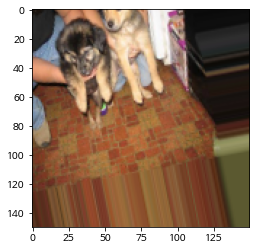

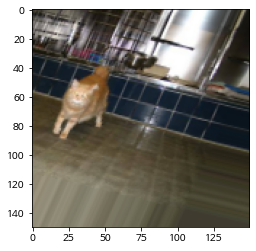

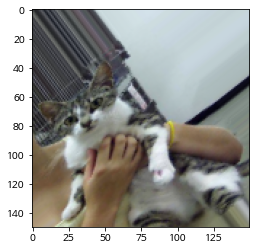

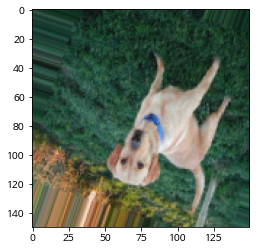

In [29]:
i = 0
for batch in datagen.flow(X_train, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break
plt.show()

In [30]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

# 검증 데이터는 증식되어서는 안 됩니다!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # 타깃 디렉터리
        train_dir,
        # 모든 이미지를 150 × 150 크기로 바꿉니다
        target_size=(150, 150),
        batch_size=32,
        # binary_crossentropy 손실을 사용하기 때문에 이진 레이블을 만들어야 합니다
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [31]:
from keras import models
from keras import layers
from tensorflow.keras import optimizers
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.BatchNormalization())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

In [32]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=20,
      epochs=50,
      validation_data=validation_generator,
      validation_steps=50)

C:\Users\user\AppData\Local\Temp/ipykernel_16432/4106837159.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/50
20/20 [==============================] - 18s 884ms/step - loss: 0.7331 - acc: 0.5625 - val_loss: 0.6915 - val_acc: 0.5000
Epoch 2/50
20/20 [==============================] - 11s 555ms/step - loss: 0.6918 - acc: 0.5913
Epoch 3/50
20/20 [==============================] - 12s 583ms/step - loss: 0.6702 - acc: 0.6047
Epoch 4/50
20/20 [==============================] - 11s 556ms/step - loss: 0.6512 - acc: 0.6219
Epoch 5/50
20/20 [==============================] - 11s 564ms/step - loss: 0.6333 - acc: 0.6406
Epoch 6/50
20/20 [==============================] - 12s 591ms/step - loss: 0.6593 - acc: 0.6170
Epoch 7/50
20/20 [==============================] - 11s 561ms/step - loss: 0.6621 - acc: 0.6234
Epoch 8/50
20/20 [==============================] - 14s 679ms/step - loss: 0.6609 - acc: 0.6156
Epoch 9/50
20/20 [==============================] - 13s 639ms/step - loss: 0.6305 - acc: 0.6406
Epoch 10/50
20/20 [==============================] - 11s 534ms/step - loss: 0.6069 - acc: 0.6672
Ep

In [33]:
model.evaluate(X_test,y_test)

32/32 [==============================] - 3s 98ms/step - loss: 370.5246 - acc: 0.6460


[370.5246276855469, 0.6460000276565552]

In [34]:
model.save('./datasets/model_3rd.h5') 

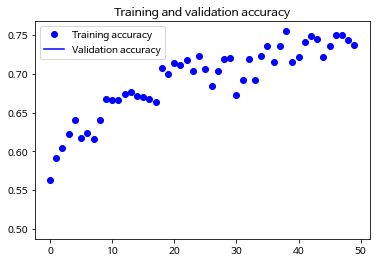

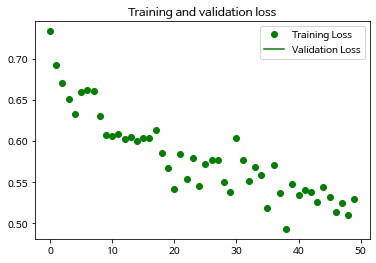

In [35]:
#그냥 내가 추가한거

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

# epochs = range(len(acc))

plt.plot(acc, 'bo', label='Training accuracy')
plt.plot(val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(loss, 'go', label='Training Loss')
plt.plot(val_loss, 'g', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()